In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
from collections import Counter
import operator
import pickle
from scipy.stats import entropy
import networkit as nk #more efficient

#plot
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d

C:\Users\camil\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\camil\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\camil\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import preprocessing_Origins,is_day,time_series_henColumn_tsRow, is_WG_open, is_day
import config_exp2 as config

C:\Users\camil\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
C:\Users\camil\anaconda3\lib\site-packages\gensim\matutils.py:24: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu
C:\Users\camil\anaconda3\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


2


In [3]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
id_run = config.id_run
dico_matching = config.dico_matching
li_tracking_date = config.li_tracking_date
print(id_run)
path_extracted_data_visual = os.path.join(path_extracted_data,'visual')
#create a director if not existing
if not os.path.exists(path_extracted_data_visual):
    os.makedirs(path_extracted_data_visual)

change the configuration file if not done yet!
EXP2_


In [20]:
os.path.join(path_extracted_data, id_run+'_daily_ALL_variables_verified.csv')

'G:\\VPHI\\Welfare\\2- Research Projects\\Camille Montalcini\\Origins.GS\\DataOutput\\TrackingSystem\\EXP2_\\EXP2__daily_ALL_variables_verified.csv'

# Download data

In [5]:
df_dailyvar = pd.read_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables_verified.csv'), sep=';', parse_dates=['level'],
                dayfirst=True) 
df_h = df_dailyvar.groupby('HenID')['CorrectPenID'].agg(lambda x: list(set(x))).reset_index()
df_h['nbrR'] = df_h['CorrectPenID'].map(lambda x: len(x))
display(df_h['nbrR'].value_counts())
df_h['Relocated'] = df_h['nbrR'].map(lambda x: x!=1)
dico_henid_isrel = dict(zip(df_h['HenID'].tolist(), df_h['Relocated'].tolist()))
display(df_dailyvar['nbr_h_per_day'].value_counts())
df_dailyvar = df_dailyvar[df_dailyvar['nbr_h_per_day']==14]
#dico_henid_isrel
print(df_dailyvar.shape)
df_dailyvar.head(3)

1    85
4    78
2     3
3     3
Name: nbrR, dtype: int64

14.0    6298
9.0      807
13.5     492
Name: nbr_h_per_day, dtype: int64

(6298, 44)


,HenID,level,perc_duration_3_Zone,perc_duration_2_Zone,perc_duration_4_Zone,perc_duration_5_Zone,Total_number_zone,mid_cum_Z4_sec,Total_number_transition,vertical_travel_distance,...,HenID_Period,HenID_date,system,CorrectPenID,duration_1_Zone_min,duration_2_Zone_min,duration_3_Zone_min,duration_4_Zone_min,duration_5_Zone_min,Has_been_toptier_wholeday
810,hen_1,2021-11-26,27.0,56.0,3.0,14.0,4.0,10216.0,48.0,48.0,...,hen_1_R1,hen_1-2021-11-26,10-12,pen10,0.0,469.583333,225.116667,29.383333,115.916667,False
811,hen_1,2021-11-27,17.0,53.0,5.0,25.0,4.0,8336.0,47.0,54.0,...,hen_1_R1,hen_1-2021-11-27,10-12,pen10,0.0,446.683333,142.183333,39.033333,212.100000,False
812,hen_1,2021-11-28,24.0,57.0,8.0,10.0,4.0,8881.0,58.0,60.0,...,hen_1_R1,hen_1-2021-11-28,10-12,pen10,0.0,479.383333,204.633333,68.216667,87.766667,False


In [6]:
df = pd.read_csv(os.path.join(path_extracted_data, id_run+'_CLEANEDDATA.csv'), sep=';', parse_dates=['Timestamp', 'date'],
                dayfirst=True) 
print(df.shape)
df.head(3)

(2099229, 23)


,Unnamed: 0,Timestamp,HenID,Zone,PenID,ts_order,TagID,signalstrength,system,time,...,zone3,zone4,next_record_date,duration,next_zone,previous_zone,is_dur_smaller_60sec,correction_is_consecutive_equal_initial_zone,is_WG_open,is_day
0,132,2021-10-08 00:24:41,hen_1,3_Zone,pen10,348506,tag_5,14,10 - 12,00:24:41,...,6,0,2021-10-08 10:59:30,38089.0,2_Zone,NaN,False,False,False,False
1,1274,2021-10-08 10:59:30,hen_1,2_Zone,pen10,348747,tag_5,5,10 - 12,10:59:30,...,0,0,2021-10-09 10:33:27,84837.0,2_Zone,3_Zone,False,False,False,True
2,6916,2021-10-09 10:33:27,hen_1,3_Zone,pen10,350158,tag_5,15,10 - 12,10:33:27,...,4,6,2021-10-09 10:59:56,1589.0,3_Zone,2_Zone,False,False,False,True


# Similarities between each day-hen

In [7]:
len(df['date'].unique())

270

In [8]:
display(df[['HenID', 'PenID', 'system','Zone','Timestamp','date','is_WG_open', 'is_day']].head(3))

,HenID,PenID,system,Zone,Timestamp,date,is_WG_open,is_day
0,hen_1,pen10,10 - 12,3_Zone,2021-10-08 00:24:41,2021-10-08,False,False
1,hen_1,pen10,10 - 12,2_Zone,2021-10-08 10:59:30,2021-10-08,False,True
2,hen_1,pen10,10 - 12,3_Zone,2021-10-09 10:33:27,2021-10-09,False,True


In [9]:
len(df['HenID'].unique())

169

In [10]:
#from li_tracking_date
li_alldate = [[dt.datetime(2021, 10, 9),
 dt.datetime(2021, 10, 10),
 dt.datetime(2021, 10, 11),
 dt.datetime(2021, 10, 16),
 dt.datetime(2021, 10, 17),
 dt.datetime(2021, 10, 18)],
 [dt.datetime(2021, 11, 23),
 dt.datetime(2021, 11, 24),
 dt.datetime(2021, 11, 25),
 dt.datetime(2021, 11, 26),
 dt.datetime(2021, 11, 27),
 dt.datetime(2021, 11, 28),
 dt.datetime(2021, 11, 29),
 dt.datetime(2021, 12, 1)],
 [dt.datetime(2022, 2, 1),
 dt.datetime(2022, 2, 2),
 dt.datetime(2022, 2, 3),
 dt.datetime(2022, 2, 4),
 dt.datetime(2022, 2, 5),
 dt.datetime(2022, 2, 6),
 dt.datetime(2022, 2, 7),
 dt.datetime(2022, 2, 9),
 dt.datetime(2022, 2, 10),
 dt.datetime(2022, 2, 11),
 dt.datetime(2022, 2, 12),
 dt.datetime(2022, 2, 13),
 dt.datetime(2022, 2, 14),
 dt.datetime(2022, 2, 15),
 dt.datetime(2022, 2, 16)],
 [dt.datetime(2022, 4, 5),
 dt.datetime(2022, 4, 6),
 dt.datetime(2022, 4, 7),
 dt.datetime(2022, 4, 8),
 dt.datetime(2022, 4, 9),
 dt.datetime(2022, 4, 10),
 dt.datetime(2022, 4, 11),
 dt.datetime(2022, 4, 13),
 dt.datetime(2022, 4, 14),
 dt.datetime(2022, 4, 15),
 dt.datetime(2022, 4, 16),
 dt.datetime(2022, 4, 17),
 dt.datetime(2022, 4, 18),
 dt.datetime(2022, 4, 19),
 dt.datetime(2022, 4, 20)],
 [dt.datetime(2022, 6, 28),
 dt.datetime(2022, 6, 29),
 dt.datetime(2022, 6, 30),
 dt.datetime(2022, 7, 1),
 dt.datetime(2022, 7, 2),
 dt.datetime(2022, 7, 3),
 dt.datetime(2022, 7, 4)]]

In [11]:
li_hens = []
for li_level in tqdm.tqdm(li_alldate):
    #decide on the level of the time serie
    nbr_sec = 1
    #add previous and last date, even if RFID was on at that time, we will use the first previous and lasst transitions 
    #to not loose an entire day
    li_add = [min(li_level)-dt.timedelta(days=1), max(li_level)+dt.timedelta(days=1)]
    li_level.extend(li_add)
    li_level = sorted(li_level)
    #print()
    #print(li_level)

    df_ = df[df['date'].isin(li_level)].copy()
    #sort by timestamp and do pivot
    df_ = df_.sort_values(['Timestamp'], ascending=True)
    x0 = df_.shape[0]

    #No need now to have no duplicate timestamp per hen:
    #df = df.groupby(['Timestamp','HenID'])[col_ts].agg(lambda x: list(x)[0]).reset_index()  
    df_hens = df_.pivot(index='Timestamp', columns='HenID', values='Zone')

    #fill "None" values with the last non-empty value (by propagating last valHenID observation forward to next valHenID)
    #In order to fill in between timestamp, ie. timestamp that another hen had, then the other should also have their latest zone 
    #entered instead of nan Note that the first ones will stay None
    df_hens = df_hens.fillna(method='ffill')
    display(df_hens.head(3))

    #Warning: not all hens have same initial/enddate!
    #add missing dates 
    mi = min(df_['Timestamp'].tolist())
    ma = max(df_['Timestamp'].tolist())
    print('The initial starting date in over all is: %s, and the ending date will be: %s'%(str(mi), str(ma)))
    print('But note that birds may have different ending and starting date which should be taken into account when computing variables')

    #add dates until minuit of the last day
    ma = dt.datetime(ma.year,ma.month,ma.day,23,59,59)
    print('and after ending the last day at midnight : %s, and the ending date will be: %s'%(str(mi), str(ma)))
    Daterange = pd.date_range(start=mi, end=ma, freq='S') 
    #take only the needed values (nbr_sec)
    Daterange = [Daterange[i] for i in range(len(Daterange)) if i%nbr_sec==0]
    #Daterange[0:10]

    #add missing seconds (i.e. all seconds that never had a record) and fillnan with last non-nan values by propagating last 
    #valHenID observation (even if its an observation that will be removed) forward to next valHenID
    df_hens = df_hens.reindex(Daterange, method='ffill').reset_index()    
    df_hens['date'] = df_hens['Timestamp'].map(lambda x: dt.datetime(x.year,x.month,x.day))
    print(df_hens.shape)
    df_hens = df_hens[~df_hens['date'].isin(li_add)]
    print(df_hens.shape)
    #remove the first and last added date
    #df_hens.to_csv(os.path.join(path_extracted_data,id_run+'_TimeSeries'+period_type+'.csv'), sep=';', index=False)

    #keep only day-time remove night-time  
    df_hens['is_day'] = df_hens['Timestamp'].map(lambda x: is_day(x, config.dico_night_hour))
    print(df_hens.shape)
    df_hens = df_hens[df_hens['is_day']]
    print(df_hens.shape)
    li_hens.append(df_hens)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

HenID,hen_1,hen_10,hen_100,hen_101,hen_102,hen_103,hen_104,hen_106,hen_107,hen_108,...,hen_90,hen_91,hen_92,hen_93,hen_94,hen_95,hen_96,hen_97,hen_98,hen_99
Timestamp,,,,,,,,,,,,,,,,,,,,,
2021-10-08 00:00:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-08 00:00:56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3_Zone,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-08 00:04:52,NaN,NaN,NaN,NaN,NaN,NaN,3_Zone,NaN,NaN,NaN,...,NaN,NaN,3_Zone,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The initial starting date in over all is: 2021-10-08 00:00:19, and the ending date will be: 2021-10-19 18:44:25
But note that birds may have different ending and starting date which should be taken into account when computing variables
and after ending the last day at midnight : 2021-10-08 00:00:19, and the ending date will be: 2021-10-19 23:59:59
(1036781, 164)
(864000, 164)
(864000, 165)


 20%|████████████████▊                                                                   | 1/5 [00:20<01:22, 20.54s/it]

(324000, 165)


HenID,hen_1,hen_10,hen_100,hen_101,hen_102,hen_103,hen_104,hen_105,hen_106,hen_107,...,hen_90,hen_91,hen_92,hen_93,hen_94,hen_95,hen_96,hen_97,hen_98,hen_99
Timestamp,,,,,,,,,,,,,,,,,,,,,
2021-11-22 00:01:32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-22 00:10:16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-22 00:33:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The initial starting date in over all is: 2021-11-22 00:01:32, and the ending date will be: 2021-12-02 23:13:39
But note that birds may have different ending and starting date which should be taken into account when computing variables
and after ending the last day at midnight : 2021-11-22 00:01:32, and the ending date will be: 2021-12-02 23:59:59
(950308, 171)
(777600, 171)
(777600, 172)


 40%|█████████████████████████████████▌                                                  | 2/5 [00:41<01:01, 20.59s/it]

(448200, 172)


HenID,hen_1,hen_10,hen_100,hen_101,hen_102,hen_103,hen_104,hen_105,hen_106,hen_107,...,hen_90,hen_91,hen_92,hen_93,hen_94,hen_95,hen_96,hen_97,hen_98,hen_99
Timestamp,,,,,,,,,,,,,,,,,,,,,
2022-01-31 00:09:33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-31 00:20:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-31 00:56:07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The initial starting date in over all is: 2022-01-31 00:09:33, and the ending date will be: 2022-02-17 22:42:29
But note that birds may have different ending and starting date which should be taken into account when computing variables
and after ending the last day at midnight : 2022-01-31 00:09:33, and the ending date will be: 2022-02-17 23:59:59
(1554627, 170)
(1382400, 170)
(1382400, 171)


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:15<00:53, 26.96s/it]

(806400, 171)


HenID,hen_1,hen_10,hen_100,hen_101,hen_102,hen_103,hen_104,hen_105,hen_106,hen_107,...,hen_90,hen_91,hen_92,hen_93,hen_94,hen_95,hen_96,hen_97,hen_98,hen_99
Timestamp,,,,,,,,,,,,,,,,,,,,,
2022-04-04 00:01:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-04 00:10:07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-04 00:13:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The initial starting date in over all is: 2022-04-04 00:01:59, and the ending date will be: 2022-04-21 23:46:42
But note that birds may have different ending and starting date which should be taken into account when computing variables
and after ending the last day at midnight : 2022-04-04 00:01:59, and the ending date will be: 2022-04-21 23:59:59
(1555081, 169)
(1382400, 169)
(1382400, 170)


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:49<00:29, 29.71s/it]

(806400, 170)


HenID,hen_1,hen_10,hen_100,hen_101,hen_102,hen_103,hen_104,hen_105,hen_107,hen_108,...,hen_9,hen_90,hen_91,hen_92,hen_93,hen_94,hen_95,hen_97,hen_98,hen_99
Timestamp,,,,,,,,,,,,,,,,,,,,,
2022-06-27 00:14:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3_Zone,NaN,NaN,NaN
2022-06-27 00:17:07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3_Zone,NaN,NaN,NaN
2022-06-27 00:27:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3_Zone,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3_Zone,NaN,NaN,NaN


The initial starting date in over all is: 2022-06-27 00:14:19, and the ending date will be: 2022-07-04 23:57:14
But note that birds may have different ending and starting date which should be taken into account when computing variables
and after ending the last day at midnight : 2022-06-27 00:14:19, and the ending date will be: 2022-07-04 23:59:59
(690341, 160)
(604800, 160)
(604800, 161)


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:04<00:00, 24.89s/it]

(352800, 161)


In [12]:
%%time
df_allhens = pd.concat(li_hens)
print(df_allhens.shape)
display(df_allhens.head(3))

(2737800, 172)


HenID,Timestamp,hen_1,hen_10,hen_100,hen_101,hen_102,hen_103,hen_104,hen_106,hen_107,...,hen_99,date,is_day,hen_105,hen_124,hen_134,hen_145,hen_29,hen_52,hen_75
115181,2021-10-09 08:00:00,2_Zone,2_Zone,3_Zone,2_Zone,5_Zone,2_Zone,2_Zone,3_Zone,3_Zone,...,3_Zone,2021-10-09,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115182,2021-10-09 08:00:01,2_Zone,2_Zone,3_Zone,2_Zone,5_Zone,2_Zone,2_Zone,3_Zone,3_Zone,...,3_Zone,2021-10-09,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115183,2021-10-09 08:00:02,2_Zone,2_Zone,3_Zone,2_Zone,5_Zone,2_Zone,2_Zone,3_Zone,3_Zone,...,3_Zone,2021-10-09,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Wall time: 1.67 s


In [13]:
%%time
li_hen = [i for i in df_allhens.columns if 'hen_' in i]
df_ = df_allhens.groupby('date')[li_hen].agg(lambda x: list(x)).reset_index()
print(df_.shape)
display(df_.head(3))
df_ = pd.melt(df_, id_vars=['date'], value_vars=li_hen, value_name = 'ts')
df_['henid_level'] = df_.apply(lambda x: x['HenID']+'-'+str(x['date']).split(' ')[0], axis=1)
dico_henidlevel_ts = dict(zip(df_['henid_level'].tolist(), df_['ts'].tolist()))
display(df_.head(3))

(58, 170)


HenID,date,hen_1,hen_10,hen_100,hen_101,hen_102,hen_103,hen_104,hen_106,hen_107,...,hen_97,hen_98,hen_99,hen_105,hen_124,hen_134,hen_145,hen_29,hen_52,hen_75
0,2021-10-09,"[2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zon...","[2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zon...","[3_Zone, 3_Zone, 3_Zone, 3_Zone, 3_Zone, 3_Zon...","[2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zon...","[2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zon...","[3_Zone, 3_Zone, 3_Zone, 3_Zone, 3_Zone, 3_Zon...","[3_Zone, 3_Zone, 3_Zone, 3_Zone, 3_Zone, 3_Zon...",...,"[3_Zone, 3_Zone, 3_Zone, 3_Zone, 3_Zone, 3_Zon...","[2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zon...","[3_Zone, 3_Zone, 3_Zone, 3_Zone, 3_Zone, 3_Zon...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
1,2021-10-10,"[2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zon...","[2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zon...","[3_Zone, 3_Zone, 3_Zone, 3_Zone, 3_Zone, 3_Zon...","[2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zon...","[3_Zone, 3_Zone, 3_Zone, 3_Zone, 3_Zone, 3_Zon...","[2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zon...",...,"[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2,2021-10-11,"[2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zon...","[2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[3_Zone, 3_Zone, 3_Zone, 3_Zone, 3_Zone, 3_Zon...","[2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zon...",...,"[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


,date,HenID,ts,henid_level
0,2021-10-09,hen_1,"[2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zon...",hen_1-2021-10-09
1,2021-10-10,hen_1,"[2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zon...",hen_1-2021-10-10
2,2021-10-11,hen_1,"[2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zon...",hen_1-2021-10-11


Wall time: 54.4 s


In [15]:
#remove hen-day removed during processing
df_hdate = df_dailyvar.groupby(['HenID'])['level'].agg(lambda x: list(x)).reset_index()
display(df_hdate.head(2))
dico_hen_dates = dict(zip(df_hdate['HenID'].tolist(),df_hdate['level'].tolist()))
print(len(dico_hen_dates))
df_['tracked'] = df_.apply(lambda x: x['date'] in dico_hen_dates[x['HenID']], axis=1)
df_['tracked'].value_counts()

,HenID,level
0,hen_1,"[2021-11-26 00:00:00, 2021-11-27 00:00:00, 202..."
1,hen_10,"[2021-11-26 00:00:00, 2021-11-27 00:00:00, 202..."


169


True     6298
False    3504
Name: tracked, dtype: int64

In [16]:
#remove hen-day not fully tracked
df_['has_nan'] = df_['ts'].map(lambda x: np.nan in x)
df_['has_nan'].value_counts()

False    9548
True      254
Name: has_nan, dtype: int64

In [17]:
print(df_.shape)
df_ = df_[df_['has_nan']==False]
print(df_.shape)
df_ = df_[df_['tracked']==True]
print(df_.shape)

(9802, 6)
(9548, 6)
(6295, 6)


In [ ]:
#for the sapce to be robust and general, we will use all. then if we want to study nich in a pen, then we can use only those
#elements from the space
n = 6295
n*(n-1)/2

In [17]:
########## compute similarities
dico_hl1hl2_sim = {}
li_henidlevel = df_['henid_level'].unique()
for k1 in tqdm.tqdm(range(0,len(li_henidlevel)-1)):
    hl1 = li_henidlevel[k1]
    li1 = dico_henidlevel_ts[hl1]
    for k2 in range(k1+1,len(li_henidlevel)): 
        hl2 = li_henidlevel[k2]
        li2 = dico_henidlevel_ts[hl2]
        #if of same length (i.e. same number of hour during the day)
        if len(li1)==len(li2):
            #percentage of seconds in a same zone during the day only
            sim_ = sum(np.array(li1)==np.array(li2))/len(li1)
            hl1hl2 = '-'.join(sorted([hl1,hl2]))
            dico_hl1hl2_sim[hl1hl2] = sim_
#save
pickle.dump(dico_hl1hl2_sim, open(os.path.join(path_extracted_data,'dico_hl1hl2_sim.pkl'), 'wb'), 
            pickle.HIGHEST_PROTOCOL)
#load
#dico_hl1hl2_sim = pickle.load(open(os.path.join(path_extracted_data,'dico_hl1hl2_sim.pkl'), 'rb'))

  0%|                                                                            | 3/6294 [07:23<258:20:29, 147.83s/it]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\camil\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\camil\AppData\Local\Temp/ipykernel_24844/1801615015.py", line 13, in <module>
    sim_ = sum(np.array(li1)==np.array(li2))/len(li1)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\camil\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2064, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\camil\anaconda3\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "C:\Us

TypeError: object of type 'NoneType' has no len()

# Extract graph

In [ ]:
plt.hist(dico_level_h1h2_sim['2021-11-23'].values());
min_sim = 0.3
#for each level computes a graph
for level_, dico_h1h2_sim_ in dico_level_h1h2_sim.items():
    dico_h1h2_sim_ = dico_level_h1h2_sim[level_]
    li_hen_level = list(dico_h1h2_sim_.keys())
    li_hen_level = list(set(list(set([k.split('-')[0] for k in li_]))+list(set([k.split('-')[1] for k in li_hen_level]))))
    len(li_hen_level)
    dico_henid_graphid = dict(zip(li_hen_level,list(range(0,len(li_hen_level)))))
    ###############################################################################################
    G = nk.Graph(len(li_hen_level), directed=False, weighted=True)
    for h1h2, sim_ in dico_h1h2_sim_.items():
        h1 = h1h2.split('-')[0]
        h2 = h1h2.split('-')[1]
        if sim_>=min_sim:
            #add edges to the graph using the ID_graph to label the nodes
            G.addEdge(dico_henid_graphid[h1], dico_henid_graphid[h2], w=sim_) #, w=np.float32(1+1/dist__)) #from 1+1/1500 to 2 #float32 for memory
    print(G.numberOfEdges(), G.numberOfNodes())
    #nk.graphio.writeGraph(G=G, path=os.path.join(path,'G_'+name+'.graph'), fileformat=nk.Format.METIS)

In [ ]:
#https://networkit.github.io/dev-docs/python_api/embedding.html
#TODO: check if the weight is accounted for
cc = nk.embedding.Node2Vec(G=G, P=1.4, Q=0.6, L=30, N=100, D=3)
cc.run() #compute all node embedding
res = cc.getFeatures()
x = np.array([res[i][0] for i in range(0,len(res))])
y = np.array([res[i][1] for i in range(0,len(res))])
z = np.array([res[i][2] for i in range(0,len(res))])

df_3dspace = pd.DataFrame.from_dict({'d1':x, 'd2':y, 'd3':z,
                                     'graphID':dico_henid_graphid.values(),
                                     'HenID':dico_henid_graphid.keys()})
dico_hensel_color = {'hen_112':'red', 'hen_15':'orange', 'hen_81':'blue'}
df_3dspace['color'] = df_3dspace['HenID'].map(lambda x: dico_hensel_color.get(x,'black'))
df_3dspace['Relocated'] = df_3dspace['HenID'].map(lambda x: int(dico_henid_isrel[x]))
print(df_3dspace.shape)
display(df_3dspace.head(3))

In [ ]:
# Creating figure
fig = plt.figure(figsize = (7, 7))
ax = plt.axes(projection ="3d")
# Add x, y gridlines
ax.grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.3, alpha = 0.2)
# Creating color map
my_cmap = plt.get_cmap('hsv')
# Creating plot
sctt = ax.scatter3D(x, y, z, alpha = 0.8, marker ='^', c=df_3dspace['color'].tolist())
#my_cmap = plt.get_cmap('hsv')
#c = (x + y + z),cmap = my_cmap,
ax.set_xlabel('X-axis', fontweight ='bold')
ax.set_ylabel('Y-axis', fontweight ='bold')
ax.set_zlabel('Z-axis', fontweight ='bold')
#ax.text3D(x, y, z, list(dico_henid_graphid.keys()))
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5);

# OLD - one per day

In [8]:
df_date = df_dailyvar.groupby('Period_type')['level'].agg(lambda x: sorted(set(x))).reset_index()
display(df_date)
dict_periodtype_lilevel = dict(zip(df_date['Period_type'].tolist(), df_date['level'].tolist()))
#dict_periodtype_lilevel
#decide on the level of the time serie
nbr_sec = 1
for period_type, li_level in dict_periodtype_lilevel.items():
    print(period_type)
    print(li_level)
    #add previous and last date, een if RFID was on at that time, we will use the first previous and lasst transitions 
    #to not loose an entire day
    li_add = [min(li_level)-dt.timedelta(days=1), max(li_level)+dt.timedelta(days=1)]
    li_level.extend(li_add)
    li_level = sorted(li_level)
    print()
    print(li_level)

    df_ = df[df['date'].isin(li_level)].copy()
    #sort by timestamp and do pivot
    df_ = df_.sort_values(['Timestamp'], ascending=True)
    x0 = df_.shape[0]

    #No need now to have no duplicate timestamp per hen:
    #df = df.groupby(['Timestamp','HenID'])[col_ts].agg(lambda x: list(x)[0]).reset_index()  
    df_hens = df_.pivot(index='Timestamp', columns='HenID', values='Zone')

    #fill "None" values with the last non-empty value (by propagating last valHenID observation forward to next valHenID)
    #In order to fill in between timestamp, ie. timestamp that another hen had, then the other should also have their latest zone 
    #entered instead of nan Note that the first ones will stay None
    df_hens = df_hens.fillna(method='ffill')
    display(df_hens.head(3))
    
    #Warning: not all hens have same initial/enddate!
    #add missing dates 
    mi = min(df_['Timestamp'].tolist())
    ma = max(df_['Timestamp'].tolist())
    print('The initial starting date in over all is: %s, and the ending date will be: %s'%(str(mi), str(ma)))
    print('But note that birds may have different ending and starting date which should be taken into account when computing variables')

    #add dates until minuit of the last day
    ma = dt.datetime(ma.year,ma.month,ma.day,23,59,59)
    print('and after ending the last day at midnight : %s, and the ending date will be: %s'%(str(mi), str(ma)))
    Daterange = pd.date_range(start=mi, end=ma, freq='S') 
    #take only the needed values (nbr_sec)
    Daterange = [Daterange[i] for i in range(len(Daterange)) if i%nbr_sec==0]
    #Daterange[0:10]

    #add missing seconds (i.e. all seconds that never had a record) and fillnan with last non-nan values by propagating last 
    #valHenID observation (even if its an observation that will be removed) forward to next valHenID
    df_hens = df_hens.reindex(Daterange, method='ffill').reset_index()    
    df_hens['date'] = df_hens['Timestamp'].map(lambda x: dt.datetime(x.year,x.month,x.day))
    print(df_hens.shape)
    df_hens = df_hens[~df_hens['date'].isin(li_add)]
    print(df_hens.shape)
    #remove the first and last added date
    #df_hens.to_csv(os.path.join(path_extracted_data,id_run+'_TimeSeries'+period_type+'.csv'), sep=';', index=False)
    
    #keep only day-time remove night-time  
    df_hens['is_day'] = df_hens['Timestamp'].map(lambda x: is_day(x, config.dico_night_hour))
    print(df_hens.shape)
    df_hens = df_hens[df_hens['is_day']]
    print(df_hens.shape)

    #compute similarities for each date  
    dico_level_h1h2_sim = {}
    for day_,df_ in tqdm.tqdm(df_hens.groupby('date')):
        li_hen = [i for i in df_.columns if 'hen_' in i]
        dico_h1h2_sim = {}
        for k1 in range(0,len(li_hen)-1):
            h1 = li_hen[k1]
            li1 = df_[h1].tolist()
            if (np.nan not in li1):
                for k2 in range(k1+1,len(li_hen)): 
                    h2 = li_hen[k2]
                    li2 = df_[h2].tolist()
                    if (np.nan not in li2) & (len(li1)==len(li2)):
                        #percentage of seconds in a same zone during the day only
                        sim_ = sum(np.array(li1)==np.array(li2))/len(li1)
                        h1h2 = '-'.join(sorted([h1,h2]))
                        dico_h1h2_sim[h1h2] = sim_
                #print('NA YOUHOUUUU')
                #print(li1)
        dico_level_h1h2_sim[str(day_).split( )[0]] = dico_h1h2_sim
    sys.exit()

,Period_type,level
0,R1,"[2021-11-23 00:00:00, 2021-11-24 00:00:00, 202..."
1,R2,"[2022-02-01 00:00:00, 2022-02-02 00:00:00, 202..."
2,R3,"[2022-04-05 00:00:00, 2022-04-06 00:00:00, 202..."
3,early,"[2021-10-09 00:00:00, 2021-10-10 00:00:00, 202..."
4,late,"[2022-06-28 00:00:00, 2022-06-29 00:00:00, 202..."


R1
[Timestamp('2021-11-23 00:00:00'), Timestamp('2021-11-24 00:00:00'), Timestamp('2021-11-25 00:00:00'), Timestamp('2021-11-26 00:00:00'), Timestamp('2021-11-27 00:00:00'), Timestamp('2021-11-28 00:00:00'), Timestamp('2021-11-29 00:00:00'), Timestamp('2021-12-01 00:00:00')]

[Timestamp('2021-11-22 00:00:00'), Timestamp('2021-11-23 00:00:00'), Timestamp('2021-11-24 00:00:00'), Timestamp('2021-11-25 00:00:00'), Timestamp('2021-11-26 00:00:00'), Timestamp('2021-11-27 00:00:00'), Timestamp('2021-11-28 00:00:00'), Timestamp('2021-11-29 00:00:00'), Timestamp('2021-12-01 00:00:00'), Timestamp('2021-12-02 00:00:00')]


HenID,hen_1,hen_10,hen_100,hen_101,hen_102,hen_103,hen_104,hen_105,hen_106,hen_107,...,hen_90,hen_91,hen_92,hen_93,hen_94,hen_95,hen_96,hen_97,hen_98,hen_99
Timestamp,,,,,,,,,,,,,,,,,,,,,
2021-11-22 00:01:32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-22 00:10:16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-22 00:33:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The initial starting date in over all is: 2021-11-22 00:01:32, and the ending date will be: 2021-12-02 23:13:39
But note that birds may have different ending and starting date which should be taken into account when computing variables
and after ending the last day at midnight : 2021-11-22 00:01:32, and the ending date will be: 2021-12-02 23:59:59
(950308, 171)
(777600, 171)
(777600, 172)
(448200, 172)


 11%|████████▉                                                                       | 1/9 [30:17<4:02:19, 1817.38s/it]


KeyboardInterrupt: 

In [ ]:
dico_level_h1h2_sim.keys()

In [ ]:
plt.hist(dico_level_h1h2_sim['2021-11-23'].values());
min_sim = 0.3
#for each level computes a graph
for level_, dico_h1h2_sim_ in dico_level_h1h2_sim.items():
    dico_h1h2_sim_ = dico_level_h1h2_sim[level_]
    li_hen_level = list(dico_h1h2_sim_.keys())
    li_hen_level = list(set(list(set([k.split('-')[0] for k in li_]))+list(set([k.split('-')[1] for k in li_hen_level]))))
    len(li_hen_level)
    dico_henid_graphid = dict(zip(li_hen_level,list(range(0,len(li_hen_level)))))
    ###############################################################################################
    G = nk.Graph(len(li_hen_level), directed=False, weighted=True)
    for h1h2, sim_ in dico_h1h2_sim_.items():
        h1 = h1h2.split('-')[0]
        h2 = h1h2.split('-')[1]
        if sim_>=min_sim:
            #add edges to the graph using the ID_graph to label the nodes
            G.addEdge(dico_henid_graphid[h1], dico_henid_graphid[h2], w=sim_) #, w=np.float32(1+1/dist__)) #from 1+1/1500 to 2 #float32 for memory
    print(G.numberOfEdges(), G.numberOfNodes())
    #nk.graphio.writeGraph(G=G, path=os.path.join(path,'G_'+name+'.graph'), fileformat=nk.Format.METIS)

In [215]:
#https://networkit.github.io/dev-docs/python_api/embedding.html
#TODO: check if the weight is accounted for
cc = nk.embedding.Node2Vec(G=G, P=1.4, Q=0.6, L=30, N=100, D=3)
cc.run() #compute all node embedding
res = cc.getFeatures()
x = np.array([res[i][0] for i in range(0,len(res))])
y = np.array([res[i][1] for i in range(0,len(res))])
z = np.array([res[i][2] for i in range(0,len(res))])

df_3dspace = pd.DataFrame.from_dict({'d1':x, 'd2':y, 'd3':z,
                                     'graphID':dico_henid_graphid.values(),
                                     'HenID':dico_henid_graphid.keys()})
dico_hensel_color = {'hen_112':'red', 'hen_15':'orange', 'hen_81':'blue'}
df_3dspace['color'] = df_3dspace['HenID'].map(lambda x: dico_hensel_color.get(x,'black'))
df_3dspace['Relocated'] = df_3dspace['HenID'].map(lambda x: int(dico_henid_isrel[x]))
print(df_3dspace.shape)
display(df_3dspace.head(3))

(164, 7)


,d1,d2,d3,graphID,HenID,color,Relocated
0,0.231637,-2.601530,-4.129779,0,hen_112,red,False
1,0.758516,-3.063151,-5.331082,1,hen_15,orange,True
2,0.509799,-2.121241,-4.334538,2,hen_81,blue,True


C:\Users\camil\AppData\Local\Temp/ipykernel_17788/4012365715.py:5: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.3,alpha = 0.2)
C:\Users\camil\AppData\Local\Temp/ipykernel_17788/4012365715.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5);


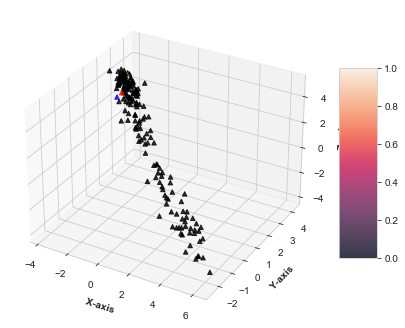

In [202]:
# Creating figure
fig = plt.figure(figsize = (7, 7))
ax = plt.axes(projection ="3d")
# Add x, y gridlines
ax.grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.3, alpha = 0.2)
# Creating color map
my_cmap = plt.get_cmap('hsv')
# Creating plot
sctt = ax.scatter3D(x, y, z, alpha = 0.8, marker ='^', c=df_3dspace['color'].tolist())
#my_cmap = plt.get_cmap('hsv')
#c = (x + y + z),cmap = my_cmap,
ax.set_xlabel('X-axis', fontweight ='bold')
ax.set_ylabel('Y-axis', fontweight ='bold')
ax.set_zlabel('Z-axis', fontweight ='bold')
#ax.text3D(x, y, z, list(dico_henid_graphid.keys()))
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5);

C:\Users\camil\AppData\Local\Temp/ipykernel_17788/4012365715.py:5: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.3,alpha = 0.2)
C:\Users\camil\AppData\Local\Temp/ipykernel_17788/4012365715.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5);


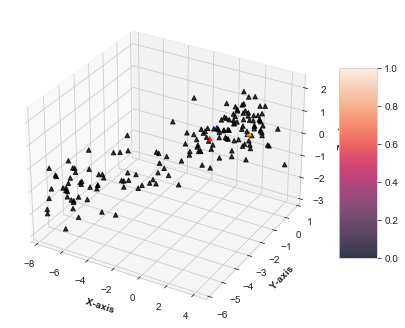

In [195]:
# Creating figure
fig = plt.figure(figsize = (7, 7))
ax = plt.axes(projection ="3d")
# Add x, y gridlines
ax.grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.3,alpha = 0.2)
# Creating color map
my_cmap = plt.get_cmap('hsv')
# Creating plot
sctt = ax.scatter3D(x, y, z, alpha = 0.8, marker ='^', c=df_3dspace['color'].tolist())
#my_cmap = plt.get_cmap('hsv')
#c = (x + y + z),cmap = my_cmap,
ax.set_xlabel('X-axis', fontweight ='bold')
ax.set_ylabel('Y-axis', fontweight ='bold')
ax.set_zlabel('Z-axis', fontweight ='bold')
#ax.text3D(x, y, z, list(dico_henid_graphid.keys()))
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5);